# Tạo các đặc trưng mới và chọn đặc trưng cần thiết

## Giới thiệu

Notebook này bao gồm các bước tiền xử lý dữ liệu để liên quan đến các đặc trưng trước khi mô mình hóa.

## Pipeline xử lý

```
Phase I: Feature Engineering
├── 1.1 Tạo đặc trưng age, km_per_year
├── 1.2 Tạo đặc trưng is_luxury
└── 1.3 Tạo đặc trưng usage_intensity

Phase II: Feature Quality Filtering
├── 2.1 Kiểm tra tính hợp lệ của đặc trưng (validity check)
├── 2.2 Loại bỏ leakage features
├── 2.3 Loại bỏ constant features (giá trị không thay đổi)
├── 2.4 Loại bỏ near-constant / low-variance features
└── 2.5. Nhận xét

Phase III: Multicollinearity Analysis
├── 3.1 Ma trận tương quan (Correlation Matrix)
├── 3.2 Tính hệ số VIF (Variance Inflation Factor)
└── 3.3 Loại bỏ các đặc trưng gây đa cộng tuyến

Phase IV: Encoding
├── 4.1 One-hot Encoding (transmission, usage, fuel_type,
│                       origin, condition, body_type)
├── 4.2 Group + One-hot Encoding (brand, city)
└── 4.3 Target Encoding (các biến high-cardinality khi cần)

Phase V: Xuất Dataset
├── 5.1 Xóa các cột categorical gốc sau khi encode
└── 5.2 Xuất file final_features.csv (dataset sẵn sàng cho modeling)

```

### Import thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from unidecode import unidecode
from datetime import datetime
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Load datasets

In [2]:
df = pd.read_csv("../data/interim/missing_interim.csv")

### I. Feature Engineering

#### 1.1 Tạo features mới

In [3]:
# age: tuổi xe (năm)
CURRENT_YEAR = datetime.now().year

df['age'] = CURRENT_YEAR - df['year']

# km_per_year: số km trung bình mỗi năm
# Xe mới (age=0) → fill = 0
df['km_per_year'] = df.apply(
    lambda row: 0 if row['age'] == 0 else row['km'] / row['age'],
    axis=1
)

# is_luxury: xe sang (1) hay xe phổ thông (0)
LUXURY_BRANDS = [
    'Mercedes Benz', 'BMW', 'Lexus', 'Porsche', 'Jaguar', 'Volvo',
    'Bentley', 'Rolls Royce', 'Maserati', 'Ferrari', 'Lamborghini',
    'Genesis'
]
df['is_luxury'] = df['brand'].isin(LUXURY_BRANDS).astype(int)

df[['brand', 'year', 'age', 'km', 'km_per_year', 'is_luxury']].head(10)

,brand,year,age,km,km_per_year,is_luxury
0,Toyota,2020.0,5.0,200000.0,40000.000000,0
1,Chevrolet,2017.0,8.0,160.0,20.000000,0
2,VinFast,2024.0,1.0,14000.0,14000.000000,0
3,Daewoo,2010.0,15.0,130000.0,8666.666667,0
4,Ford,2017.0,8.0,120.0,15.000000,0
5,Toyota,2002.0,23.0,50000.0,2173.913043,0
6,Volkswagen,2022.0,3.0,16850.0,5616.666667,0
7,VinFast,2022.0,3.0,50000.0,16666.666667,0
8,Mitsubishi,2023.0,2.0,9979.0,4989.500000,0
9,Mercedes Benz,2019.0,6.0,70000.0,11666.666667,1


In [4]:
# Kiểm tra phân bố is_luxury
print(f"Số xe sang: {df['is_luxury'].sum()} ({df['is_luxury'].mean()*100:.1f}%)")
print(f"\nThống kê age và km_per_year:")
df[['age', 'km_per_year']].describe()

Số xe sang: 2622 (19.1%)

Thống kê age và km_per_year:


,age,km_per_year
count,13723.000000,13723.000000
mean,6.002332,10342.493043
std,5.434656,9987.831078
min,0.000000,0.000000
25%,2.000000,1428.571429
50%,5.000000,9571.428571
75%,9.000000,14500.000000
max,30.000000,100000.000000


#### 1.2 Usage Intensity

Phân loại mức độ sử dụng xe dựa trên km_per_year:

In [5]:
# Phân loại mức độ sử dụng xe
def classify_usage(km_per_year):
    if km_per_year < 10000:
        return 1
    elif km_per_year <= 20000:
        return 2
    else:
        return 3
df['usage'] = df['km_per_year'].apply(classify_usage)

# Kiểm tra phân bố
print("Phân bố usage:")
print(df['usage'].value_counts())
print(f"\nTỷ lệ:")
print(df['usage'].value_counts(normalize=True) * 100)

Phân bố usage:
usage
1    7067
2    5193
3    1463
Name: count, dtype: int64

Tỷ lệ:
usage
1    51.497486
2    37.841580
3    10.660934
Name: proportion, dtype: float64


In [6]:
df.head(10)

,price_million,km,year,brand,model,transmission,fuel_type,body_type,origin,condition,seats,city,engine,engine_missing,seller_id,source,age,km_per_year,is_luxury,usage
0,210.0,200000.0,2020.0,Toyota,Wigo,MT,Xăng,Hatchback,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,bf8ec81ff74b13e68547baef01123083,chotot,5.0,40000.000000,0,3
1,295.0,160.0,2017.0,Chevrolet,Colorado,MT,Dầu,Pick-up (bán tải),Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,3555f5e4f94d1553395b639630ea6ce1,chotot,8.0,20.000000,0,1
2,589.0,14000.0,2024.0,VinFast,VF6,AT,Điện,SUV / Cross over,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,7ed3e52ff9b6ad18a9cdb3f92c2b0e0e,chotot,1.0,14000.000000,0,2
3,105.0,130000.0,2010.0,Daewoo,Gentra,MT,Xăng,Sedan,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,fdde5dfa7299cd0d29b7cc2926b42a07,chotot,15.0,8666.666667,0,1
4,415.0,120.0,2017.0,Ford,Ranger,AT,Dầu,Pick-up (bán tải),Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,4c8bf38251a85124c7a32597682fbca1,chotot,8.0,15.000000,0,1
5,125.0,50000.0,2002.0,Toyota,Camry,MT,Xăng,Sedan,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,54603360f9989d5c8a08eb9ac8eaeb1a,chotot,23.0,2173.913043,0,1
6,700.0,16850.0,2022.0,Volkswagen,T-Cross,AT,Xăng,SUV / Cross over,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0.0,1,c7c1ae46e1165992da72ad03742175a3,chotot,3.0,5616.666667,0,1
7,440.0,50000.0,2022.0,VinFast,VFe34,AT,Điện,SUV / Cross over,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,70cb05d7a18a7ab67e9fffc2ab2bf760,chotot,3.0,16666.666667,0,2
8,579.0,9979.0,2023.0,Mitsubishi,Xpander,AT,Xăng,SUV / Cross over,Nhập khẩu,Cũ,7.0,Hồ Chí Minh,0.0,1,e2c4d3cf25d0bcca8df95e03f702c9e7,chotot,2.0,4989.500000,0,1
9,950.0,70000.0,2019.0,Mercedes Benz,C Class,AT,Xăng,Sedan,Trong nước,Cũ,5.0,Hồ Chí Minh,0.0,1,a25e2ec163d1dedd55c8f4f283afac27,chotot,6.0,11666.666667,1,2


#### 1.3 Lưu dữ liệu

In [7]:
df.to_csv('../datasets/non_encoded_car_features.csv', index=False)
df.to_csv('../data/interim/feature_interim.csv', index=False)

print(f"Đã lưu dataset: ../datasets/non_encoded_car_features.csv")
print(f"Kích thước: {df.shape[0]} rows x {df.shape[1]} cols")

Đã lưu dataset: ../datasets/non_encoded_car_features.csv
Kích thước: 13723 rows x 20 cols


### II. Feature Quality Filtering

#### 2.1 Kiểm tra tính hợp lệ của đặc trưng (validity check)

### 2.1.1 Numeric Range Validation

Kiểm tra các biến số để đảm bảo rằng giá trị không vượt domain vật lý và không chứa lỗi parse.

Các biến cần kiểm tra:

- **price_million**: > 0
- **km**: >= 0 và < 500,000
- **year**: nằm trong khoảng 1995–2025
- **age**: >= 0
- **km_per_year**: >= 0 và không vượt 100,000
- **engine**: nằm trong khoảng hợp lý (0–6000 cc)

Nếu phát hiện giá trị bất thường:
- In ra số lượng
- Xem record lỗi
- Sửa hoặc loại tùy theo mức độ


In [8]:
invalid_numeric = {"price_million_invalid": df[df["price_million"] <= 0],
                   "km_invalid": df[(df["km"] < 0) | (df["km"] > 500_000)],
                   "year_invalid": df[(df["year"] < 1995) | (df["year"] > 2025)], "age_invalid": df[df["age"] < 0],
                   "km_per_year_invalid": df[df["km_per_year"] > 100_000],
                   "engine_invalid": df[(df["engine"].notna()) & ((df["engine"] < 0) | (df["engine"] > 6000))]}

for k, v in invalid_numeric.items():
    print(f"{k}: {len(v)}")


price_million_invalid: 0
km_invalid: 0
year_invalid: 0
age_invalid: 0
km_per_year_invalid: 0
engine_invalid: 0


### 2.1.2 Categorical Validity Check

Mục tiêu:
- Đảm bảo các biến phân loại không chứa giá trị rác, sai chính tả, ký tự kỳ lạ.
- Kiểm tra rằng phân phối không lệch bất thường (dominating class > 99% → cần xem xét ở bước low-variance).

Danh sách biến phân loại:

- brand
- model
- transmission
- fuel_type
- body_type
- origin
- condition
- seats
- city
- source
- usage
- is_luxury
- engine_missing

Kiểm tra bao gồm:
- Xem danh sách unique của từng cột
- Tìm giá trị bất thường: "", "nan", "unknown", None
- Kiểm tra kiểu dữ liệu


In [9]:
categorical_cols = [
    "brand","model","transmission","fuel_type","body_type",
    "origin","condition","seats","city","source",
    "usage","is_luxury","engine_missing"
]

for col in categorical_cols:
    print("="*60)
    print(f"Feature: {col}")
    print("Unique values:", df[col].unique()[:20])  # show first 20
    print("Num unique:", df[col].nunique())
    print("Value counts:")
    print(df[col].value_counts(normalize=True).head())


Feature: brand
Unique values: ['Toyota' 'Chevrolet' 'VinFast' 'Daewoo' 'Ford' 'Volkswagen' 'Mitsubishi'
 'Mercedes Benz' 'BMW' 'Kia' 'Suzuki' 'Nissan' 'Hyundai' 'Honda' 'Porsche'
 'Mazda' 'Audi' 'Isuzu' 'MG' 'LandRover']
Num unique: 84
Value counts:
brand
Toyota           0.174306
Ford             0.100488
Mercedes Benz    0.098448
Hyundai          0.089558
Kia              0.083218
Name: proportion, dtype: float64
Feature: model
Unique values: ['Wigo' 'Colorado' 'VF6' 'Gentra' 'Ranger' 'Camry' 'T-Cross' 'VFe34'
 'Xpander' 'C Class' 'Dòng khác' 'Attrage' 'Limo Green' 'Innova'
 'Carnival' 'Cruze' 'Ertiga' '3 Series' 'Sunny' 'Land Cruiser']
Num unique: 1400
Value counts:
model
Innova     0.017926
GLC 300    0.012752
Xpander    0.012388
Vios       0.011222
Morning    0.010712
Name: proportion, dtype: float64
Feature: transmission
Unique values: ['MT' 'AT']
Num unique: 2
Value counts:
transmission
AT    0.854624
MT    0.145376
Name: proportion, dtype: float64
Feature: fuel_type
Unique valu

Kiểm tra và lọc bỏ đi các dòng xe nhi hơn 9 chỗ, tập trung vào phân khúc xe con

In [10]:
df_high_seats = df[df["seats"] > 9].copy()
df = df[df["seats"] <= 9].copy()

print("Số lượng xe có seats > 9:", len(df_high_seats))
print("Số lượng xe có seats < 9:", len(df))
df[["brand", "model", "body_type", "seats"]].head(10)

Số lượng xe có seats > 9: 136
Số lượng xe có seats < 9: 13587


,brand,model,body_type,seats
0,Toyota,Wigo,Hatchback,5.0
1,Chevrolet,Colorado,Pick-up (bán tải),5.0
2,VinFast,VF6,SUV / Cross over,5.0
3,Daewoo,Gentra,Sedan,5.0
4,Ford,Ranger,Pick-up (bán tải),5.0
5,Toyota,Camry,Sedan,5.0
6,Volkswagen,T-Cross,SUV / Cross over,5.0
7,VinFast,VFe34,SUV / Cross over,5.0
8,Mitsubishi,Xpander,SUV / Cross over,7.0
9,Mercedes Benz,C Class,Sedan,5.0


### 2.1.3 Missing Value Validation

Kiểm tra xem mỗi đặc trưng có đang chứa NaN hay không.

Yêu cầu:
- **Được phép NaN**: seller_id

Hành động:
- In ra số lượng NaN để đánh giá


In [11]:
print(df.isna().sum().sort_values(ascending=False))

seller_id         166
price_million       0
year                0
km                  0
brand               0
model               0
fuel_type           0
transmission        0
origin              0
condition           0
seats               0
body_type           0
city                0
engine              0
engine_missing      0
source              0
age                 0
km_per_year         0
is_luxury           0
usage               0
dtype: int64


### 2.1.4 Structural Relationship Validation

Kiểm tra các quan hệ toán học và logic giữa các feature:

1. **age vs year**
   - age phải đúng bằng (current_year - year)

2. **km_per_year vs km + age**
   - km_per_year ≈ km / max(age,1)

3. **engine_missing vs engine**
   - engine_missing == 1 → engine phải là 0.0
   - engine_missing == 0 → engine phải khác 0.0

4. **brand vs model**
   - model không được trùng với brand hoàn toàn

Nếu phát hiện bất thường:
- In record lỗi
- Cân nhắc sửa hoặc loại record


In [12]:
invalid_age = df[df["age"] != (CURRENT_YEAR - df["year"])]
invalid_km_year = df[df["km_per_year"] > (df["km"] / df["age"].clip(lower=1) * 2)]
invalid_engine_flag = df[
    ((df["engine_missing"] == 1) & (df["engine"] != 0.0)) |
    ((df["engine_missing"] == 0) & (df["engine"].isna()))
]

invalid_brand_model = df[df["brand"].str.lower() == df["model"].str.lower()]

print("Invalid age records:", len(invalid_age))
print("Invalid km/year records:", len(invalid_km_year))
print("Invalid engine_missing records:", len(invalid_engine_flag))
print("Invalid brand/model records:", len(invalid_brand_model))


Invalid age records: 0
Invalid km/year records: 0
Invalid engine_missing records: 0
Invalid brand/model records: 0


### 2.2 Loại bỏ leakage features

Mục tiêu:
- Loại bỏ các đặc trưng có thể gây rò rỉ thông tin (data leakage) trong quá trình huấn luyện mô hình.
- Leakage xảy ra khi mô hình được cung cấp thông tin mà trong thực tế **không thể biết tại thời điểm dự đoán**, hoặc thông tin khiến mô hình dự đoán dựa trên ID thay vì đặc tính xe.

Trong dataset này, các leakage features bao gồm:

#### 1. `seller_id`
- Đây là định danh của người bán.
- Mô hình có thể học rằng:
  - Một số người bán có thói quen đăng xe giá cao hơn/thấp hơn.
  - Xe của cùng một người bán có giá tương tự nhau.
- Điều này gây **overfitting mạnh** và **không thể áp dụng khi dự đoán cho người bán mới**.
- Do đó `seller_id` phải bị loại bỏ hoàn toàn trước modeling.

#### 2. `source`
- Không phải leakage theo nghĩa strict, nhưng thuộc **metadata của dữ liệu**, không liên quan đến xe.
- Giá xe ở Chotot và Bonbanh có thể chênh lệch do thị trường, không do đặc tính xe.
- Giữ `source` cho modeling có thể khiến mô hình học chệch theo nguồn dữ liệu thay vì đặc điểm xe.
- Nếu mục tiêu là mô hình hóa giá chung cho toàn bộ thị trường → **khuyến nghị drop**.

#### Giữ lại (không phải leakage):
- `brand`, `model`, `city`, `year`, `km`, `condition`, etc. đều là thông tin quan sát được tại thời điểm dự đoán → không bị xem là leakage.



In [13]:
leakage_features = ["seller_id", 'source'] # Nếu muốn loại cả 'source' để tránh bias theo nguồn thêm

df = df.drop(columns=leakage_features, errors="ignore")

print("Đã loại bỏ leakage features:", leakage_features)
print("Các cột còn lại:", df.columns.tolist())

Đã loại bỏ leakage features: ['seller_id', 'source']
Các cột còn lại: ['price_million', 'km', 'year', 'brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'seats', 'city', 'engine', 'engine_missing', 'age', 'km_per_year', 'is_luxury', 'usage']


### 2.3 Loại bỏ constant features

Mục tiêu:
- Loại bỏ các đặc trưng **không mang thông tin** (no variance), tức là các cột mà toàn bộ giá trị đều giống nhau.
- Các cột dạng này không đóng góp giá trị cho mô hình học máy và còn gây nặng pipeline.

#### Khi nào một feature được xem là constant?
- Khi `nunique() == 1`
  Ví dụ:
  - 100% giá trị = "used"
  - 100% giá trị = "Vietnam"
  - 100% = 0 hoặc 1

#### Khi nào một feature là near-constant (tạm thời chưa loại)?
- Khi một giá trị chiếm trên 99% tổng số (dominant value > 99%)
- Near-constant **không loại ở bước này**, vì chúng cần xử lý riêng ở bước 2.4 (low-variance features).

#### Mục đích của bước này:
- Bảo đảm giữ lại chỉ những feature có khả năng phân biệt giữa các mẫu.
- Giảm số chiều không cần thiết.
- Giảm sai số mô hình do noise hoặc giá trị dummy.



In [14]:
# Tìm tất cả cột constant: chỉ có 1 giá trị phân biệt
constant_features = [col for col in df.columns if df[col].nunique() == 1]

print("Constant features:", constant_features)

# Loại bỏ
df = df.drop(columns=constant_features, errors="ignore")

print("Đã loại bỏ constant features.")
print("Số cột còn lại:", len(df.columns))

Constant features: []
Đã loại bỏ constant features.
Số cột còn lại: 18


### 2.4 Loại bỏ near-constant / low-variance features

Mục tiêu:
- Xác định và loại bỏ các đặc trưng có **độ biến thiên rất thấp**, tức là một giá trị chiếm áp đảo (dominant) trong toàn bộ tập dữ liệu.
- Đây là những đặc trưng không mang thông tin hữu ích cho mô hình vì:
  - Hầu như tất cả mẫu đều giống nhau → mô hình không thể học quy luật phân biệt.
  - Chúng chỉ làm nhiễu và tăng kích thước không cần thiết.

---

### Tiêu chí xác định near-constant feature

Một feature được xem là *near-constant* nếu:

- Tỷ lệ xuất hiện của giá trị phổ biến nhất (`dominant_rate`) > **0.98** (98%)
  (Có thể dùng threshold 95% hoặc 99% tùy mô hình, nhưng 98% là thông dụng.)

Công thức:

```
dominant_rate = df[col].value_counts(normalize=True).max()
if dominant_rate > 0.98 → near-constant → loại bỏ
```

---

### Ví dụ near-constant trong dataset xe:
- `condition` = "Cũ" với tỉ lệ 88% → **không near-constant**, vẫn giữ.
- `seats` = 5 chỗ chiếm 63% → **không near-constant**.
- `is_luxury` = 0 chiếm 80% → **không near-constant**.
- Nếu có cột nào > 98% → nên loại.

---

### Lưu ý:
- Khác với constant feature (100% giống nhau), near-constant chỉ bị loại khi **thật sự áp đảo**.
- Loại bỏ near-constant được thực hiện **sau** khi đã loại leakage và constant features.



In [15]:
near_constant_features = []

threshold = 0.98  # dominant rate threshold

for col in df.columns:
    dominant_rate = df[col].value_counts(normalize=True, dropna=False).max()
    if dominant_rate > threshold:
        near_constant_features.append(col)
        print(f"{col}: dominant rate = {dominant_rate:.4f}")

print("\nNear-constant features:", near_constant_features)

# Loại bỏ
df = df.drop(columns=near_constant_features, errors="ignore")

print("Đã loại near-constant features.")
print("Số cột còn lại:", len(df.columns))


Near-constant features: []
Đã loại near-constant features.
Số cột còn lại: 18


#### 2.5 Nhận xét

Giai đoạn Feature Quality Filtering bao gồm bốn bước: kiểm tra tính hợp lệ của đặc trưng, loại bỏ leakage features, loại bỏ constant features và loại bỏ near-constant features. Mục tiêu của các bước này là đảm bảo rằng các đặc trưng sử dụng cho mô hình hoá đều hợp lệ, không gây sai lệch, không chứa nhiễu và có khả năng đóng góp thông tin cho mô hình.

Kết quả đánh giá cho thấy:

1. **Validity Check**
   - Không phát hiện sai lệch nghiêm trọng trong các biến số và biến phân loại.
   - Một số giá trị `NaN` xuất hiện ở một số cột (như `seats`, `engine`), được xem là hợp lệ và sẽ xử lý tại bước imputation hoặc encoding.
   - Các giá trị lớn bất thường trong `seats` (trên 9 chỗ) được xác định thuộc nhóm xe ngoài phạm vi bài toán và đã được xử lý tại bước domain filtering.

2. **Leakage Feature Removal**
   - `seller_id` được loại bỏ vì là biến định danh người bán và có nguy cơ gây rò rỉ thông tin.
   - Các biến khác không thuộc nhóm leakage và được giữ lại.

3. **Constant Feature Removal**
   - Không có đặc trưng nào là constant (chỉ có một giá trị duy nhất), do đó không có biến bị loại ở bước này.

4. **Near-constant Feature Removal**
   - Không phát hiện đặc trưng nào có dominant rate vượt ngưỡng 98%.
   - Tất cả các đặc trưng còn lại có độ biến thiên đủ lớn để duy trì trong mô hình.

Sau khi hoàn tất các bước trên, tập biến hiện tại đã được làm sạch, không chứa leakage, không có biến vô giá trị, và có phân phối hợp lý.


### IV Multicollinearity Analysis

### 4.1 Ma trận tương quan (Correlation Matrix)

Mục tiêu:
- Kiểm tra mức độ tương quan tuyến tính giữa các biến số nhằm phát hiện khả năng tồn tại đa cộng tuyến.
- Các biến có tương quan quá cao (|corr| > 0.8 hoặc > 0.9 tuỳ ngưỡng) có thể gây bất ổn cho các mô hình tuyến tính (Linear Regression, Ridge, Lasso) hoặc làm giảm khả năng giải thích.

Lưu ý:
- Chỉ áp dụng cho **biến số (numeric features)**.
- Các biến one-hot (sau encoding) sẽ sinh ra tương quan giả → phần này cần thực hiện **trước khi OHE** nhưng **sau khi hoàn tất Feature Engineering**.
- Không xem xét target `price_million` trong phân tích multicollinearity.

Cách tiếp cận:
1. Lọc danh sách các numeric features.
2. Tính ma trận tương quan Pearson.
3. Quan sát các cặp tương quan cao để chuẩn bị đánh giá VIF (ở bước 3.2).


In [16]:
# Lấy numeric features (loại target và các cột không số)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Loại target để không ảnh hưởng phân tích multicollinearity
if "price_million" in numeric_cols:
    numeric_cols.remove("price_million")

numeric_cols

['km',
 'year',
 'seats',
 'engine',
 'engine_missing',
 'age',
 'km_per_year',
 'is_luxury',
 'usage']

In [17]:
# Tính correlation matrix
corr_matrix = df[numeric_cols].corr(method="pearson")
corr_matrix

,km,year,seats,engine,engine_missing,age,km_per_year,is_luxury,usage
km,1.000000,-0.578526,0.077760,-0.160971,0.244312,0.578526,0.509928,-0.061025,0.444081
year,-0.578526,1.000000,-0.018565,0.126232,-0.258345,-1.000000,0.059882,-0.021181,0.122888
seats,0.077760,-0.018565,1.000000,0.057487,-0.004922,0.018565,0.089279,-0.186265,0.108668
engine,-0.160971,0.126232,0.057487,1.000000,-0.846332,-0.126232,-0.091831,0.361000,-0.064659
engine_missing,0.244312,-0.258345,-0.004922,-0.846332,1.000000,0.258345,0.085020,-0.243034,0.042342
age,0.578526,-1.000000,0.018565,-0.126232,0.258345,1.000000,-0.059882,0.021181,-0.122888
km_per_year,0.509928,0.059882,0.089279,-0.091831,0.085020,-0.059882,1.000000,-0.098210,0.842660
is_luxury,-0.061025,-0.021181,-0.186265,0.361000,-0.243034,0.021181,-0.098210,1.000000,-0.125742
usage,0.444081,0.122888,0.108668,-0.064659,0.042342,-0.122888,0.842660,-0.125742,1.000000


### Nhận xét từ ma trận tương quan

Kết quả phân tích tương quan giữa các đặc trưng số cho thấy:

1. **`age` và `year` có tương quan tuyến tính hoàn hảo (corr = –1.0)**.
   Đây là dạng đa cộng tuyến nghiêm trọng vì `age` được tính trực tiếp từ `year`.
   Do đó bắt buộc phải loại một trong hai biến.
   Trong bài toán dự đoán giá xe, `age` là đặc trưng mang ý nghĩa thực tế hơn nên sẽ giữ `age` và loại `year`.

2. Các cặp biến còn lại có độ tương quan từ thấp đến trung bình, không vượt các ngưỡng thường dùng để xác định đa cộng tuyến cao (|corr| > 0.85 hoặc > 0.90).
   Do đó chúng không gây rủi ro cho mô hình tuyến tính.

3. Một số biến có tương quan đáng chú ý nhưng không nghiêm trọng:
   - `km` và `age`: corr ~ 0.58
   - `km_per_year` và `usage`: corr ~ 0.84 (sẽ kiểm tra tiếp bằng VIF ở bước 4.2)

Nhìn chung, **đa cộng tuyến chỉ tồn tại giữa `year` và `age`**, và sẽ được xử lý bằng cách loại bỏ `year` ở bước 4.3.


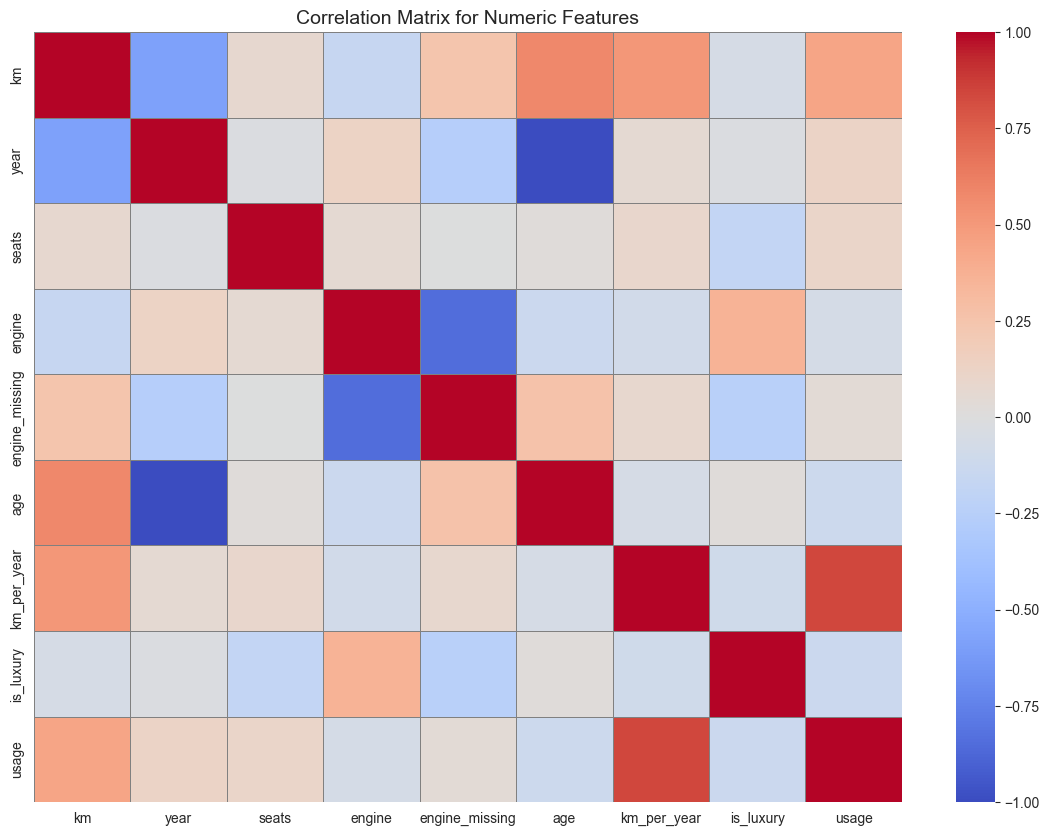

In [18]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Correlation Matrix for Numeric Features", fontsize=14)
plt.show()


### Nhận xét heatmap

Heatmap cho thấy phần lớn các cặp biến đều có mức tương quan thấp đến trung bình, không xuất hiện các cụm màu đậm kéo dài biểu thị tương quan cao.
Duy nhất một cặp thể hiện tương quan tuyệt đối là **`year` và `age`**, phản ánh mối quan hệ tuyến tính trực tiếp giữa hai biến. Đây là dấu hiệu đa cộng tuyến hoàn hảo và sẽ cần xử lý ở bước tiếp theo.


### 3.2 Tính hệ số VIF (Variance Inflation Factor)

Mục tiêu:
- Đánh giá mức độ đa cộng tuyến giữa các biến số bằng cách đo lường mức độ một biến có thể được giải thích bởi các biến còn lại.
- VIF càng cao → biến càng có nhiều thông tin trùng lặp → gây bất ổn cho mô hình tuyến tính.

Cách diễn giải:
- VIF = 1 → không có đa cộng tuyến
- 1 ≤ VIF < 5 → mức chấp nhận được
- 5 ≤ VIF < 10 → đa cộng tuyến đáng chú ý (cân nhắc loại bỏ)
- VIF ≥ 10 → đa cộng tuyến nghiêm trọng (nên loại)

Lưu ý:
- Chỉ áp dụng cho **numeric features**.
- Không chạy VIF trên biến sau One-Hot Encoding (vì tạo dummy trap).
- `year` đã bị loại nhờ tương quan hoàn hảo với `age`, nên không cần đưa vào VIF.


In [19]:
# Lấy numeric columns hiện tại
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Loại target nếu có
if "price_million" in numeric_cols:
    numeric_cols.remove("price_million")

# Tạo dataframe để tính VIF
X = df[numeric_cols].copy()

# Loại các cột có tất cả giá trị NaN hoặc constant (nếu còn)
X = X.loc[:, X.apply(lambda col: col.nunique() > 1)]
X = X.dropna()  # VIF yêu cầu không NaN

X.head()


,km,year,seats,engine,engine_missing,age,km_per_year,is_luxury,usage
0,200000.0,2020.0,5.0,0.0,1,5.0,40000.000000,0,3
1,160.0,2017.0,5.0,0.0,1,8.0,20.000000,0,1
2,14000.0,2024.0,5.0,0.0,1,1.0,14000.000000,0,2
3,130000.0,2010.0,5.0,0.0,1,15.0,8666.666667,0,1
4,120.0,2017.0,5.0,0.0,1,8.0,15.000000,0,1


In [20]:
vif_result = pd.DataFrame()
vif_result["feature"] = X.columns
vif_result["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]
vif_result.sort_values(by="VIF", ascending=False)

,feature,VIF
1,year,44.562236
5,age,4.847392
3,engine,4.089916
4,engine_missing,3.946028
6,km_per_year,3.877752
8,usage,3.670599
0,km,2.828498
7,is_luxury,1.248000
2,seats,1.079661


### Nhận xét VIF

Kết quả VIF cho thấy chỉ có một biến duy nhất gây đa cộng tuyến nghiêm trọng là `year` với VIF ≈ 44.56. Điều này là hoàn toàn hợp lý vì `age` được tính trực tiếp từ `year`, dẫn đến mối quan hệ tuyến tính hoàn hảo giữa hai biến (corr = –1.0).

Do đó, `year` cần được loại bỏ để tránh bất ổn trong các mô hình tuyến tính.

Các đặc trưng còn lại đều có VIF dưới 5, cho thấy mức độ đa cộng tuyến thấp và không ảnh hưởng đáng kể đến mô hình. Vì vậy, chúng được giữ lại cho các bước tiếp theo.


### 3.3 Loại bỏ các đặc trưng gây đa cộng tuyến

Dựa trên kết quả từ:
- Heatmap tương quan (mục 3.1)
- Chỉ số VIF (mục 3.2)

Ta quan sát thấy:

- `year` và `age` có tương quan tuyến tính hoàn hảo (corr = –1.0).
- `year` có VIF ≈ 44.56 — vượt xa ngưỡng 10, biểu hiện đa cộng tuyến nghiêm trọng.
- Điều này hoàn toàn hợp lý vì `age` được tính trực tiếp từ `year`.

Hệ quả:
- Nếu giữ cả hai biến, các mô hình tuyến tính sẽ không ổn định
- Coefficient sẽ dao động mạnh theo dữ liệu
- Ma trận thiết kế có thể gần như suy biến (singular)

Quyết định:
- Giữ `age` (đặc trưng giàu ý nghĩa và phù hợp với domain)
- Loại bỏ `year` (biến gốc gây đa cộng tuyến)

Không có biến số nào khác vượt ngưỡng VIF cần loại bỏ.
Các biến như `km`, `km_per_year`, `usage`, `engine`, `seats` đều có VIF < 5 và được giữ lại.


In [21]:
# Loại biến gây đa cộng tuyến nghiêm trọng
cols_to_drop = ["year"]

df = df.drop(columns=cols_to_drop, errors="ignore")

print("Đã loại bỏ các biến gây đa cộng tuyến:", cols_to_drop)
print("Số lượng cột còn lại:", len(df.columns))

Đã loại bỏ các biến gây đa cộng tuyến: ['year']
Số lượng cột còn lại: 17


### Nhận xét

Sau khi loại bỏ `year`, tập biến còn lại không còn mối quan hệ tuyến tính mạnh nào gây ảnh hưởng đến mô hình.
Các biến khác có VIF từ 1 đến dưới 5, nằm trong mức an toàn.
Dataset hiện tại đã loại bỏ toàn bộ đa cộng tuyến nghiêm trọng và sẵn sàng cho bước mã hóa (Encoding).


### IV. Encoding

#### Tổng quan

In [22]:
# Xem số lượng unique values của các cột categorical
cat_cols = ['brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'city',  'usage']
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

brand: 84 unique values
model: 1375 unique values
transmission: 2 unique values
fuel_type: 4 unique values
body_type: 17 unique values
origin: 2 unique values
condition: 2 unique values
city: 60 unique values
usage: 3 unique values


**Chiến lược encoding:**
- **Binary Encoding:** `transmission` (2 values), `origin` (2 values), `condition` (2 values), `source` (2 values)
- **One-hot Encoding:** `usage` (3 values) `fuel_type` (4 values), `body_type` (17 values after grouping)
- **Group + One-hot:** `brand` (85 → group thành ~20), `city` (60 → group thành ~15)
- **Target Encoding:** `model` (1400 values - quá nhiều cho one-hot)

#### 4.1 One-hot Encoding

Sử dụng cho các feature ít đa dạng, là một tập hữu hạn có số phần tử

In [23]:
def normalize_categorical(x, mapping=None, keywords_map=None):
    """
    x: giá trị cần chuẩn hóa
    mapping: dict {giá trị chuẩn hóa: value mới}, khớp exact
    keywords_map: dict {từ khóa: value mới}, nếu từ khóa xuất hiện trong x -> map
    """
    if pd.isna(x):
        return np.nan

    val = str(x).lower().strip()

    # 1. khớp exact mapping
    if mapping and val in mapping:
        return mapping[val]

    # 2. khớp theo từ khóa
    if keywords_map:
        for kw, kw_val in keywords_map.items():
            if kw in val:
                return kw_val

    # 3. fallback
    return val

##### 4.1.1 Transmission

In [24]:
print(df['transmission'].value_counts())

transmission
AT    11728
MT     1859
Name: count, dtype: int64


In [25]:
df['transmission_binary'] = df['transmission'].str.lower().map({
    'at': 1,
    'mt': 0
})
print(df[['transmission', 'transmission_binary']].head(5))

  transmission  transmission_binary
0           MT                    0
1           MT                    0
2           AT                    1
3           MT                    0
4           AT                    1


##### 4.1.2 Fuel_type

In [26]:
print(df['fuel_type'].value_counts())

fuel_type
Xăng      10598
Dầu        1861
Điện        727
Hybrid      401
Name: count, dtype: int64


In [27]:
# Chuẩn hóa giá trị trước
fuel_mapping = {
    'xăng': 'gasoline',
    'dầu': 'diesel',
    'điện': 'electric',
    'hybrid': 'hybrid'
}
df['fuel_type'] = df['fuel_type'].apply(lambda x: normalize_categorical(x, mapping=fuel_mapping))

# Tạo các cột one-hot
fuel_dummies = pd.get_dummies(df['fuel_type'], prefix='fuel')

# Ép kiểu bool -> int (True/False -> 1/0)
fuel_dummies = fuel_dummies.astype(int)

# Nối vào df
df = pd.concat([df, fuel_dummies], axis=1)

# Kiểm tra
print(df[['fuel_type'] + list(fuel_dummies.columns)].head(10))

  fuel_type  fuel_diesel  fuel_electric  fuel_gasoline  fuel_hybrid
0  gasoline            0              0              1            0
1    diesel            1              0              0            0
2  electric            0              1              0            0
3  gasoline            0              0              1            0
4    diesel            1              0              0            0
5  gasoline            0              0              1            0
6  gasoline            0              0              1            0
7  electric            0              1              0            0
8  gasoline            0              0              1            0
9  gasoline            0              0              1            0


##### 4.1.3 Origin

In [28]:
print(df['origin'].value_counts())

origin
Trong nước    7312
Nhập khẩu     6275
Name: count, dtype: int64


In [29]:
df['inland_binary'] = df['origin'].str.lower().map({
    'trong nước': 1,
    'nhập khẩu': 0
})

print(df[['origin', 'inland_binary']].head(5))

       origin  inland_binary
0   Nhập khẩu              0
1   Nhập khẩu              0
2  Trong nước              1
3  Trong nước              1
4   Nhập khẩu              0


##### 4.1.4 Condition

In [30]:
print(df['condition'].value_counts())

condition
Cũ     11910
Mới     1677
Name: count, dtype: int64


In [31]:
df['new_binary'] = df['condition'].str.lower().map({
    'mới': 1,
    'cũ': 0
})

print(df[['condition', 'new_binary']].head(5))

  condition  new_binary
0        Cũ           0
1        Cũ           0
2        Cũ           0
3        Cũ           0
4        Cũ           0


##### 4.1.5 Body_type

In [32]:
print(df['body_type'].value_counts())

body_type
SUV                      4462
Sedan                    3749
SUV / Cross over         1425
Hatchback                1070
Crossover                 746
Bán tải / Pickup        500
Minivan (MPV)             499
Van/Minivan               466
Pick-up (bán tải)         210
Kiểu dáng khác            168
Van                       129
Coupe                      53
Convertible/Cabriolet      43
Coupe (2 cửa)              37
Truck                      27
Mui trần                    2
Wagon                       1
Name: count, dtype: int64


In [33]:
# 1. Mapping chuẩn hóa body_type
body_type_mapping = {
    'suv': 'suv',
    'suv / cross over': 'suv',
    'crossover': 'suv',
    'sedan': 'sedan',
    'hatchback': 'hatchback',
    'van/minivan': 'minivan',
    'van': 'minivan',
    'minivan (mpv)': 'minivan',
    'bán tải / pickup': 'pickup',
    'pick-up (bán tải)': 'pickup',
    'coupe': 'coupe',
    'coupe (2 cửa)': 'coupe',
    'convertible/cabriolet': 'convertible',
    'truck': 'truck',
    'wagon': 'wagon',
    'mui trần': 'convertible',
    'kiểu dáng khác': 'other'
}

# Chuẩn hóa body_type
df['body_type'] = df['body_type'].apply(lambda x: normalize_categorical(x, mapping=body_type_mapping))

# One-hot encoding
style_dummies = pd.get_dummies(df['body_type'], prefix='body_type')

# Ép kiểu bool -> int (True/False -> 1/0)
style_dummies = style_dummies.astype(int)

# Nối vào df
df = pd.concat([df, style_dummies], axis=1)

# Kiểm tra
print(df[['body_type'] + list(style_dummies.columns)].head(10))

   body_type  body_type_convertible  body_type_coupe  body_type_hatchback  \
0  hatchback                      0                0                    1   
1     pickup                      0                0                    0   
2        suv                      0                0                    0   
3      sedan                      0                0                    0   
4     pickup                      0                0                    0   
5      sedan                      0                0                    0   
6        suv                      0                0                    0   
7        suv                      0                0                    0   
8        suv                      0                0                    0   
9      sedan                      0                0                    0   

   body_type_minivan  body_type_other  body_type_pickup  body_type_sedan  \
0                  0                0                 0                0   


#### 4.2 Gom nhóm

Dữ liệu có số lượng nhiều nhưng không quá lớn, có thể dùng được one-hot, gom nhóm lại các dữ liệu dưới ngưỡng để giảm bớt số feature và nhiễu

In [34]:
THRESHOLD_RATIO=0.005

In [35]:
def normalize_group_onehot_safe(df, col, threshold_ratio=0.005, other_label='other', keep_values=None):
    """
    chuẩn hóa cột, gom nhóm giá trị ít xuất hiện thành 'other' (trừ các giá trị trong keep_values)
    và tạo one-hot cho cột đó, **không thay đổi cột gốc**.

    df: dataframe
    col: tên cột gốc
    threshold_ratio: tỷ lệ tối thiểu để giữ giá trị riêng lẻ
    other_label: nhãn cho nhóm rare
    keep_values: list các giá trị luôn giữ, không gom vào other (ví dụ: ['unknow'])

    trả về:
      - df_copy: dataframe với các cột one-hot mới (tên cột: col_value)
      - list các giá trị giữ lại (không bị gom vào other)
    """
    if keep_values is None:
        keep_values = ['unknow']

    # 1. tạo cột chuẩn hóa tạm
    col_norm = df[col].astype(str).apply(lambda x: unidecode(x).lower().replace(' ', '_'))

    # 2. đếm tần suất
    counts = col_norm.value_counts()

    # 3. threshold
    total = len(df)
    threshold = max(threshold_ratio * total, 1)

    # 4. giá trị giữ lại theo threshold
    valid_values = set(counts[counts >= threshold].index)

    # 5. luôn giữ các giá trị trong keep_values
    valid_values.update([v.lower() for v in keep_values])

    # 6. gom nhóm rare → other
    col_grouped = col_norm.where(col_norm.isin(valid_values), other_label)

    # 7. one-hot
    one_hot = pd.get_dummies(col_grouped, prefix=col)

    # 8. trả về df copy (không chạm cột gốc) và list valid_values
    df_copy = pd.concat([df.copy(), one_hot], axis=1)

    return df_copy, list(valid_values)

##### 4.2.1 City

In [36]:
print("Số tỉnh/thành khác nhau: ", len(df['city'].value_counts()))
print(df['city'].value_counts())

Số tỉnh/thành khác nhau:  60
city
Hà Nội            6481
Hồ Chí Minh       3498
Bình Dương         412
Đà Nẵng            345
Hải Phòng          316
Đồng Nai           267
Đắk Lắk            154
unknow             148
Cần Thơ            133
Lâm Đồng           119
Bà Rịa             112
Vĩnh Phúc          111
Phú Thọ            109
Gia Lai             99
Nghệ An             92
Bắc Ninh            88
Thanh Hóa           73
Quảng Ninh          73
Thái Nguyên         61
Khác                59
Tây Ninh            58
Khánh Hòa           57
Long An             51
Hải Dương           47
Thừa Thiên Huế      39
Ninh Bình           38
An Giang            38
Quảng Nam           35
Thái Bình           33
Hưng Yên            32
Nam Định            32
Đồng Tháp           29
Bắc Giang           29
Hà Tĩnh             29
Quảng Ngãi          27
Bình Thuận          25
Bình Định           25
Hà Giang            19
Đắk Nông            18
Kiên Giang          15
Lào Cai             14
Vĩnh Long           14


In [37]:
# Áp dụng hàm normalize_group_onehot_safe
df, kept_values = normalize_group_onehot_safe(df, 'city', threshold_ratio=THRESHOLD_RATIO)

# Chuyển cột one-hot từ bool -> int (0/1)
city_columns = [col for col in df.columns if col.startswith('city_')]
df[city_columns] = df[city_columns].astype(int)

# Kiểm tra
print("Số tỉnh/thành phố còn lại:", len(kept_values))
print("Các tỉnh/thành phố giữ lại:", kept_values)
print(df.head(10))

Số tỉnh/thành phố còn lại: 18
Các tỉnh/thành phố giữ lại: ['bac_ninh', 'thanh_hoa', 'dak_lak', 'vinh_phuc', 'ba_ria', 'unknow', 'ho_chi_minh', 'quang_ninh', 'phu_tho', 'nghe_an', 'dong_nai', 'ha_noi', 'da_nang', 'binh_duong', 'can_tho', 'lam_dong', 'gia_lai', 'hai_phong']
   price_million        km          brand     model transmission fuel_type  \
0          210.0  200000.0         Toyota      Wigo           MT  gasoline   
1          295.0     160.0      Chevrolet  Colorado           MT    diesel   
2          589.0   14000.0        VinFast       VF6           AT  electric   
3          105.0  130000.0         Daewoo    Gentra           MT  gasoline   
4          415.0     120.0           Ford    Ranger           AT    diesel   
5          125.0   50000.0         Toyota     Camry           MT  gasoline   
6          700.0   16850.0     Volkswagen   T-Cross           AT  gasoline   
7          440.0   50000.0        VinFast     VFe34           AT  electric   
8          579.0    9979.

##### 4.2.2 Brand

In [38]:
print("Số brand khác nhau: ", len(df['brand'].value_counts()))
print(df['brand'].value_counts())

Số brand khác nhau:  84
brand
Toyota           2386
Mercedes Benz    1350
Ford             1271
Hyundai          1212
Kia              1142
                 ... 
SsangYong           1
Hummer              1
Citroen             1
BAIC                1
Renault             1
Name: count, Length: 84, dtype: int64


In [39]:
# Áp dụng normalize_group_onehot_safe cho brand
df, kept_values = normalize_group_onehot_safe(df, 'brand', threshold_ratio=THRESHOLD_RATIO)

# Chuyển các cột one-hot brand_* từ bool -> int
brand_columns = [col for col in df.columns if col.startswith('brand_')]
df[brand_columns] = df[brand_columns].astype(int)

# Kiểm tra kết quả
print("Số brand còn lại:", len(kept_values))
print("Các brand giữ lại:", kept_values)
print(df.head(10))

Số brand còn lại: 24
Các brand giữ lại: ['honda', 'ford', 'mg', 'kia', 'hyundai', 'mercedes_benz', 'audi', 'nissan', 'mazda', 'landrover', 'toyota', 'bmw', 'porsche', 'vinfast', 'unknow', 'lexus', 'chevrolet', 'suzuki', 'isuzu', 'daewoo', 'peugeot', 'mitsubishi', 'volvo', 'volkswagen']
   price_million        km          brand     model transmission fuel_type  \
0          210.0  200000.0         Toyota      Wigo           MT  gasoline   
1          295.0     160.0      Chevrolet  Colorado           MT    diesel   
2          589.0   14000.0        VinFast       VF6           AT  electric   
3          105.0  130000.0         Daewoo    Gentra           MT  gasoline   
4          415.0     120.0           Ford    Ranger           AT    diesel   
5          125.0   50000.0         Toyota     Camry           MT  gasoline   
6          700.0   16850.0     Volkswagen   T-Cross           AT  gasoline   
7          440.0   50000.0        VinFast     VFe34           AT  electric   
8          

#### 4.3 Target Encoding

In [40]:
def kfold_target_encode(train_model, target, test_model=None, n_splits=5, min_samples_leaf=1, smoothing=1, random_state=None):
    """
    train_model: categorical model của train
    target: numeric target model của train
    test_model: categorical model của test (nếu có)
    n_splits: số fold
    min_samples_leaf: minimum samples cho smoothing
    smoothing: hệ số smoothing
    """
    # Global mean
    global_mean = target.mean()

    # KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    train_encoded = pd.Series(index=train_model.index, dtype=float)

    for train_idx, val_idx in kf.split(train_model):
        # Split
        tr, val = train_model.iloc[train_idx], train_model.iloc[val_idx]
        tr_target = target.iloc[train_idx]

        # Compute category mean & count
        averages = tr_target.groupby(tr).agg(['mean', 'count'])

        # Smoothing
        smoothing_factor = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
        averages['te'] = global_mean * (1 - smoothing_factor) + averages['mean'] * smoothing_factor

        # Map to validation fold
        train_encoded.iloc[val_idx] = val.map(averages['te'])

    # Encode test set if given
    if test_model is not None:
        # Compute category mean on full train
        averages_full = target.groupby(train_model).agg(['mean', 'count'])
        smoothing_factor = 1 / (1 + np.exp(-(averages_full['count'] - min_samples_leaf) / smoothing))
        averages_full['te'] = global_mean * (1 - smoothing_factor) + averages_full['mean'] * smoothing_factor

        test_encoded = test_model.map(averages_full['te']).fillna(global_mean)
        return train_encoded, test_encoded

    return train_encoded

In [41]:
# Chuẩn hóa tên model
df['model'] = df['model'].apply(lambda x: unidecode(str(x)).lower().replace(' ', '_') if pd.notna(x) else x)

# Kiểm tra số lượng giá trị duy nhất
print(f"Số lượng model duy nhất: {df['model'].nunique()}")
print(f"Top 10 model phổ biến:\n{df['model'].value_counts().head(10)}")

# Áp dụng target encoding cho cột model
# Sử dụng KFold để tránh data leakage
df['model_encoded'] = kfold_target_encode(
    train_model=df['model'],
    target=df['price_million'],
    n_splits=5,
    min_samples_leaf=1,
    smoothing=1,
    random_state=42
)

# Xử lý NaN: fill bằng global mean của price_million
df['model_encoded'] = df['model_encoded'].fillna(df['price_million'].mean())

print(f"\n✓ Đã áp dụng Target Encoding cho cột 'model'")
print(f"Giá trị model_encoded:\n{df['model_encoded'].describe()}")

# Giữ lại cột model gốc để tham khảo, sẽ xóa trước khi train model
print(f"\nDữ liệu mẫu:")
print(df[['model', 'model_encoded', 'price_million']].head(10))

Số lượng model duy nhất: 1372
Top 10 model phổ biến:
model
innova        246
glc_300       175
xpander       170
vios          154
morning       147
ranger_xls    142
dong_khac     134
fortuner      131
ranger        130
accent        126
Name: count, dtype: int64

✓ Đã áp dụng Target Encoding cho cột 'model'
Giá trị model_encoded:
count    13587.000000
mean      1007.218043
std       1213.943265
min         69.890797
25%        409.555556
50%        643.715188
75%       1043.104752
max      12646.339593
Name: model_encoded, dtype: float64

Dữ liệu mẫu:
      model  model_encoded  price_million
0      wigo     281.550853          210.0
1  colorado     394.760828          295.0
2       vf6     680.148284          589.0
3    gentra      91.647166          105.0
4    ranger     608.284404          415.0
5     camry     423.714286          125.0
6   t-cross    1043.104752          700.0
7     vfe34     419.482858          440.0
8   xpander     477.985612          579.0
9   c_class     664.

#### 4.4 Lưu lại dữ liệu

In [42]:
df.head(10)
df.to_csv('../data/interim/encoding_interim.csv', index=False)

### VII. Lưu Dataset

#### 7.1 Xóa các cột không cần thiết

In [43]:
# Danh sách các cột cần xóa
cols_to_drop = [
    'brand', 'model', 'transmission', 'fuel_type',
    'body_type', 'origin', 'condition', 'city',
]

# Xóa các cột này khỏi df
df.drop(columns=cols_to_drop, inplace=True)

# Kiểm tra lại DataFrame
print("Các cột còn lại:", df.columns.tolist())

Các cột còn lại: ['price_million', 'km', 'seats', 'engine', 'engine_missing', 'age', 'km_per_year', 'is_luxury', 'usage', 'transmission_binary', 'fuel_diesel', 'fuel_electric', 'fuel_gasoline', 'fuel_hybrid', 'inland_binary', 'new_binary', 'body_type_convertible', 'body_type_coupe', 'body_type_hatchback', 'body_type_minivan', 'body_type_other', 'body_type_pickup', 'body_type_sedan', 'body_type_suv', 'body_type_truck', 'body_type_wagon', 'city_ba_ria', 'city_bac_ninh', 'city_binh_duong', 'city_can_tho', 'city_da_nang', 'city_dak_lak', 'city_dong_nai', 'city_gia_lai', 'city_ha_noi', 'city_hai_phong', 'city_ho_chi_minh', 'city_lam_dong', 'city_nghe_an', 'city_other', 'city_phu_tho', 'city_quang_ninh', 'city_thanh_hoa', 'city_unknow', 'city_vinh_phuc', 'brand_audi', 'brand_bmw', 'brand_chevrolet', 'brand_daewoo', 'brand_ford', 'brand_honda', 'brand_hyundai', 'brand_isuzu', 'brand_kia', 'brand_landrover', 'brand_lexus', 'brand_mazda', 'brand_mercedes_benz', 'brand_mg', 'brand_mitsubishi', '

#### Xuất dữ liệu

In [44]:
df.to_csv('../datasets/preprocessed_car_features.csv', index=False)
df.to_csv('../data/processed/preprocessed_car_features.csv', index=False)
print(f"Đã lưu dataset: ../datasets/preprocessed_car_features.csv")
print(f"Kích thước: {df.shape[0]} rows x {df.shape[1]} cols")

Đã lưu dataset: ../datasets/preprocessed_car_features.csv
Kích thước: 13587 rows x 70 cols
